# Метод ближайших соседей - lab2

## Алгоритм

### Ядра

In [524]:
import math

class Kernel:
    @staticmethod
    def uniform(u):
        return Kernel.generalized(u, 1, 0)
    
    @staticmethod
    def gaussian(u):
        return math.exp(-1 * math.pow(u, 2) / 2)
    
    @staticmethod
    def triangular(u):
        return Kernel.generalized(u, 1, 1)
    
    @staticmethod
    def epanechnikov(u):
        return Kernel.generalized(u, 2, 1)
    
    @staticmethod
    def generalized(u, a, b):
        return (1 - (abs(u) ** a)) ** b if abs(u) < 1 else 0


### Реализация алгоритма

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

class NearestNeighborsClassifier:
    def __init__(self, k=3, metric='minkowski', kernel='uniform', window=None, weights=None, p=2, a=1, b=1):
        self.k = k
        self.metric=metric
        self.window = window
        self.weights = weights
        self.p=p
        self.a=a
        self.b=b

        if kernel == 'uniform':
            self.kernel = Kernel.uniform
        elif kernel == 'triangular':
            self.kernel = Kernel.triangular
        elif kernel == 'gaussian':
            self.kernel = Kernel.gaussian
        elif kernel == 'epanechnikov':
            self.kernel = Kernel.epanechnikov
        else:
            self.kernel = lambda u: Kernel.generalized(u, a, b)

        self.nn_model = NearestNeighbors(metric=self.metric, p=self.p)

    # Метод для совметимости с Optuna
    def get_params(self, deep=True):
        return {
            "k": self.k,
            "metric": self.metric,
            "kernel": self.kernel,
            "window": self.window,
            "weights": self.weights,
            "p": self.p,
            "a": self.a,
            "b": self.b
        }

    # Метод для совместимости с Optuna
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)

        if self.kernel == 'uniform':
            self.kernel = Kernel.uniform
        elif self.kernel == 'triangular':
            self.kernel = Kernel.triangular
        elif self.kernel == 'gaussian':
            self.kernel = Kernel.gaussian
        elif self.kernel == 'epanechnikov':
            self.kernel = Kernel.epanechnikov
        else:
            self.kernel = lambda u: Kernel.generalized(u, self.a, self.b)

        self.nn_model = NearestNeighbors(metric=self.metric, p=self.p)
        
        return self
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.nn_model.fit(X_train)

    def predict(self, X_test):
        predictions = []

        # Вычисляем расстояния между всеми точками тестового множества и тренировочного
        distances, indeces = self.nn_model.kneighbors(X_test, n_neighbors=len(self.X_train))

        # Рассматриваем каждую точку тестового множества и её расстояния до точек тренировочного
        for dist, ind in zip(distances, indeces):
            # Считаем апостериорные веса
            if self.window is None:
                aposteriori_weights = [self.kernel(d / dist[self.k]) if dist[self.k] != 0 else 1 for d in dist]
            else:
                aposteriori_weights = [self.kernel(d / self.window) for d in dist]
            
            # Учитываем априорные веса
            if self.weights is None:
                weights = aposteriori_weights
            else:
                weights = [aposteriori_weights[i] * self.weights[ind[i]] for i in range(len(aposteriori_weights))]
            
            # Считаем веса всех классов соседей
            labels = {label: 0 for label in np.unique(self.y_train)}
            for i in range(len(weights)):
                labels[self.y_train[ind[i]]] += weights[i]

            # Находим класс с максимальным весом
            label = max(labels, key=labels.get)
            predictions.append(label)

        return predictions

## Набор данных

Возьмем набор данных из прошлой лабораторной - `preproc_dataset.tsv`.
Подготовим его к работе алгоритма. Целевым категориальным признаком выберем **parfume_type**.

### Предобработка

In [544]:
import pandas as pd
df = pd.read_csv('data/preproc_dataset.tsv', sep='\t', quoting=1)

#### Заполнение пропусков

In [545]:
df['rating'] = df['rating'].transform(lambda x: x.fillna(0))
df['ratings_count'] = df['ratings_count'].transform(lambda x: x.fillna(0))

#### One-Hot Encoding

Преобразуем категориальные признак **for_whom** с помощью One-Hot Encoding. 

In [546]:
df = pd.get_dummies(df, columns=['for_whom'])

##### Преобразуем признаки-списки с помощью One-Hot Encoding

Для **aroma_group** возьмем все значения (всего 17) 

In [547]:
m = set()
for row in df['aroma_group']:
    if (pd.isna(row)):
        continue
    for w in row.split(';'):
        m.add(w)

for group in m:
    df['aroma_group_{0}'.format(group)] = 0

In [548]:
def update_aroma_groups(row):
    if pd.isna(row['aroma_group']):
        return row
    aromas = row['aroma_group'].split(';')
    for aroma in aromas:
        row[f'aroma_group_{aroma}'] = 1
    return row

df = df.apply(update_aroma_groups, axis=1)

Для списков '**top_notes**', '**mid_notes**', '**base_notes**' возьмем топ 100 популярных значений, так как общее значение очень велико

In [549]:
def encode_array(df, col, top):
    # Считаем частоту сколько встречается каждый из элементов
    d = dict()
    for row in df[col]:
        if (pd.isna(row)):
            continue
        for w in row.split(';'):
            d[w] = d.setdefault(w, 0) + 1

    # Находим топ самых популярных элементов
    i = 0
    top_elements = set()
    for name, _ in sorted(d.items(), key=lambda x: x[1], reverse=True):
        top_elements.add(name.replace(' ', '_'))
        i += 1
        if i == top:
            break

    for element in top_elements:
        df[f'{col}_{element}'] = 0

    # Обновляем значения в каждом ряду таблицы
    def update_aroma_groups(row, col):
        if pd.isna(row[col]):
            return row

        initial_elemets = row[col].split(';')
        for element in initial_elemets:
            col_name = f'{col}_{element.replace(' ', '_')}'
            if col_name in df.columns:
                row[col_name] = 1
        return row

    # Применяем функцию ко всем строкам DataFrame
    df = df.apply(lambda x: update_aroma_groups(x, col), axis=1)
    df.drop(columns=[col])


In [550]:
encode_array(df, 'top_notes', 100)
encode_array(df, 'mid_notes', 100)
encode_array(df, 'base_notes', 100)


C:\Users\ladyp\AppData\Local\Temp\ipykernel_13420\3163085542.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{element}'] = 0
C:\Users\ladyp\AppData\Local\Temp\ipykernel_13420\3163085542.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{element}'] = 0
C:\Users\ladyp\AppData\Local\Temp\ipykernel_13420\3163085542.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

In [551]:
df = df.drop(columns=['aroma_group', 'top_notes', 'mid_notes', 'base_notes'])

Для признака **brand** Возьмем топ 99 брендов, а остальные вынесем в категорию other

In [552]:
top_n = 99
top_brands = df['brand'].value_counts().nlargest(top_n).index
df['brand'] = df['brand'].apply(lambda x: x if x in top_brands else 'other')
df = pd.get_dummies(df, columns=['brand'])


Для признаков **brand_country** и **produce_country** возьмем топ 14 стран, а остальные вынесем в категорию other

In [553]:
top_n = 14

top_brand_countrys = df['brand_country'].value_counts().nlargest(top_n).index
df['brand_country'] = df['brand_country'].apply(lambda x: x if x in top_brand_countrys else 'other')
df = pd.get_dummies(df, columns=['brand_country'])

top_produce_countrys = df['produce_country'].value_counts().nlargest(top_n).index
df['produce_country'] = df['produce_country'].apply(lambda x: x if x in top_produce_countrys else 'other')
df = pd.get_dummies(df, columns=['produce_country'])

Добавим дополнительный признак для случая, когда у товара нет отзывов

In [554]:
df['has_reviews'] = df['ratings_count'] > 0

#### Выбор признаков и разделение на выборки
Возьмем для работы все признаки, кроме текстовых ( **title**, **url**, **article**, **description** )

In [555]:
df = df.drop(columns=['url', 'article', 'description', 'title'])

Разделим на обучающую , тестовую выборки и переведем целевой признак в *LabelEncoding*

In [556]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = df.drop(columns=['parfume_type'])
y = label_encoder.fit_transform(df['parfume_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

#### Нормализуем числовые значения в выборках

Применим Min-Max нормализацию для числовых признаков

In [557]:
def minmax(x, min, max):
    return (float(x) - min) / (max - min)

In [558]:
for category in ['full_price_rub', 'sale_price_rub', 'volume_ml', 'rating', 'ratings_count']:
    col_train = X_train[category]
    col_test = X_test[category]
    X_train[category] = X_train[category].apply(lambda x: minmax(x, col_train.min(), col_train.max()))
    X_test[category] = X_test[category].apply(lambda x: minmax(x, col_test.min(), col_test.max()))

Итоговое число признаков

In [559]:
print(X_train.shape[1])

458


### Выбор функции ошибки

Так как решаем задачу классификации, то выираем между *accuracy* и *F1-score*. В случае определения типа парфюма, как кажется не имеет значения, какую функцию использовать. Выберем *accuracy*

## Гиперпараметры

Для подбора оптимальных гиперпараметром будем использовать библиотеку `optuna`

In [ ]:
import optuna
from sklearn.metrics import accuracy_score


### Для функции соседей

In [566]:
def objective_neighbor(trial):
    k = trial.suggest_int("k", 1, 20)

    metric = trial.suggest_categorical('metric', ['cosine', 'minkowski'])
    p = trial.suggest_int("p", 1, 5)

    kernel = trial.suggest_categorical('kernel', ['gaussian', 'generalized'])
    a = trial.suggest_int('a', 1, 4)
    b = trial.suggest_int('b', 0, 4)
    
    knn = NearestNeighborsClassifier(k=k, metric=metric, kernel=kernel, p=p, a=a, b=b)
    knn.fit(X_train.values, y_train)
    
    y_pred = knn.predict(X_test.values)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [567]:
study_n = optuna.create_study(direction="maximize")
study_n.optimize(objective_neighbor, n_trials=100, show_progress_bar=True)

[I 2024-11-01 20:05:47,908] A new study created in memory with name: no-name-e966ab41-f581-473a-80fa-8c96fd9e83d2


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-01 20:05:53,006] Trial 0 finished with value: 0.611659192825112 and parameters: {'k': 1, 'metric': 'minkowski', 'p': 1, 'kernel': 'generalized', 'a': 4, 'b': 2}. Best is trial 0 with value: 0.611659192825112.
[I 2024-11-01 20:05:58,523] Trial 1 finished with value: 0.6807174887892377 and parameters: {'k': 2, 'metric': 'cosine', 'p': 1, 'kernel': 'gaussian', 'a': 3, 'b': 4}. Best is trial 1 with value: 0.6807174887892377.
[I 2024-11-01 20:06:04,020] Trial 2 finished with value: 0.6502242152466368 and parameters: {'k': 9, 'metric': 'cosine', 'p': 2, 'kernel': 'gaussian', 'a': 3, 'b': 3}. Best is trial 1 with value: 0.6807174887892377.
[I 2024-11-01 20:06:09,480] Trial 3 finished with value: 0.715695067264574 and parameters: {'k': 12, 'metric': 'minkowski', 'p': 1, 'kernel': 'generalized', 'a': 2, 'b': 0}. Best is trial 3 with value: 0.715695067264574.
[I 2024-11-01 20:06:18,220] Trial 4 finished with value: 0.6860986547085202 and parameters: {'k': 20, 'metric': 'minkowski', 'p

In [568]:
print(study_n.best_params)
print(study_n.best_value)

{'k': 9, 'metric': 'minkowski', 'p': 1, 'kernel': 'generalized', 'a': 3, 'b': 0}
0.7255605381165919



##### Лучшие параметры:
- k = 9
- p = 1
- metric: 'minkowski' 
- kernel: 'generalized'
- a: 3
- b: 0

Учитывая значения параметров p, b, k, можно конкретизировать ядро и метрику:
- metric: 'manhattan'
- kernel: 'uniform'

Значение: 0.7255605381165919

### Для фиксированного окна

In [571]:
def objective_window(trial):
    window = trial.suggest_float('window', 0.1, 15)
    
    metric = trial.suggest_categorical('metric', ['cosine', 'minkowski'])
    p = trial.suggest_int('p', 1, 5)

    kernel = trial.suggest_categorical('kernel', ['gaussian', 'generalized'])
    a = trial.suggest_int('a', 1, 4)
    b = trial.suggest_int('b', 0, 4)

    knn = NearestNeighborsClassifier(window=window, metric=metric, kernel=kernel, p=p, a=a, b=b)
    knn.fit(X_train.values, y_train)
    
    y_pred = knn.predict(X_test.values)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [572]:
study_w = optuna.create_study(direction="maximize")
study_w.optimize(objective_window, n_trials=100, show_progress_bar=True)

[I 2024-11-01 20:20:37,967] A new study created in memory with name: no-name-4efe1def-1b15-42d1-9a54-f218a9f27cc8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-01 20:20:45,187] Trial 0 finished with value: 0.600896860986547 and parameters: {'window': 10.22264156734718, 'metric': 'minkowski', 'p': 4, 'kernel': 'gaussian', 'a': 3, 'b': 2}. Best is trial 0 with value: 0.600896860986547.
[I 2024-11-01 20:20:52,102] Trial 1 finished with value: 0.44035874439461886 and parameters: {'window': 0.69592952412888, 'metric': 'minkowski', 'p': 4, 'kernel': 'generalized', 'a': 1, 'b': 4}. Best is trial 0 with value: 0.600896860986547.
[I 2024-11-01 20:21:00,781] Trial 2 finished with value: 0.600896860986547 and parameters: {'window': 2.5129437023984225, 'metric': 'minkowski', 'p': 3, 'kernel': 'generalized', 'a': 2, 'b': 1}. Best is trial 0 with value: 0.600896860986547.
[I 2024-11-01 20:21:06,707] Trial 3 finished with value: 0.600896860986547 and parameters: {'window': 13.095517428851911, 'metric': 'cosine', 'p': 4, 'kernel': 'generalized', 'a': 2, 'b': 4}. Best is trial 0 with value: 0.600896860986547.
[I 2024-11-01 20:21:12,539] Trial 4 fin

In [573]:
print(study_w.best_params)
print(study_w.best_value)

{'window': 2.7337108647535895, 'metric': 'minkowski', 'p': 1, 'kernel': 'generalized', 'a': 4, 'b': 4}
0.705829596412556


##### Лучшие параметры:
- window = 2.7337108647535895
- p = 1
- metric: 'minkowski'
- kernel: 'generalized'
- a = 4
- b = 4

Значение: 0.705829596412556

### Построение графика

Так как лучшим оказался метод с фиксированным числом соседей, переберем возможные значения соседей

In [575]:
from tqdm import tqdm

k_values = range(1, 26)

metric = 'minkowski'
p = 1

kernel = 'generalized'
a = 3
b = 0

train_accuracies = []
test_accuracies = []

for k in tqdm(k_values):
    knn = NearestNeighborsClassifier(k=k, metric=metric, kernel=kernel, p=1, a=a, b=b)

    knn.fit(X_train.values, y_train)

    y_test_pred = knn.predict(X_test.values)
    y_train_pred = knn.predict(X_train.values)

    test_accuracies.append(accuracy_score(y_test, y_test_pred))
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

100%|██████████| 25/25 [11:39<00:00, 27.97s/it]


In [576]:
pd.DataFrame(train_accuracies).to_csv('data/train_accuraces.csv', index=False)
pd.DataFrame(test_accuracies).to_csv('data/test_accuraces.csv', index=False)

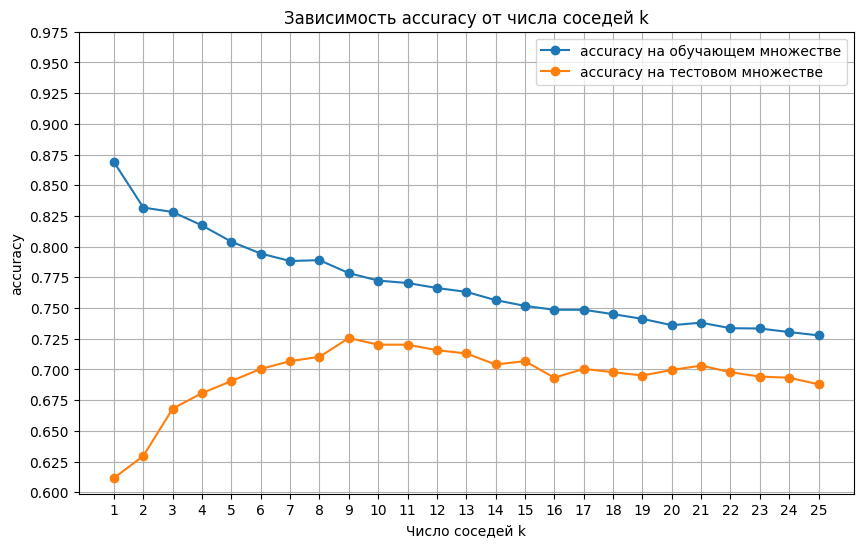

In [578]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='accuracy на обучающем множестве', marker='o')
plt.plot(k_values, test_accuracies, label='accuracy на тестовом множестве', marker='o')
plt.xlabel('Число соседей k')
plt.xticks(k_values)
plt.ylabel('accuracy')
plt.yticks(np.arange(0.6, 1, 0.025))
plt.title('Зависимость accuracy от числа соседей k')
plt.legend()
plt.grid()
plt.show()

## Поиск аномалий

### Алгоритм LOWESS

In [579]:
from sklearn.neighbors import NearestNeighbors

class LOWESS:
    def __init__(self, window=0.5, kernel=kernel, metric='minkowski', p=2, a=1, b=1):
        self.window = window
        self.metric = metric
        self.p = p
        self.a = a
        self.b = b

        if kernel is Kernel.generalized:
            self.kernel = lambda u: Kernel.generalized(u, self.a, self.b)
        else:
            self.kernel = kernel

        self.nn_model = NearestNeighbors(metric=self.metric, p=p)
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.nn_model.fit(X_train)

    def predict(self):
        predictions = []
        
        # Вычисляем расстояния между всеми точками тестового множества и обучающего
        distances, indeces = self.nn_model.kneighbors(X=X_train, n_neighbors=len(X_train))
        
        current_ind = 0
        for dist, ind in zip(distances, indeces):
            # Применяем функцию ядра
            weights = [self.kernel(d / self.window) for d in dist]
            
            # Взвешиваем классы
            labels = {label: 0 for label in np.unique(self.y_train)}
            for i in range(len(weights)):
                labels[self.y_train[ind[i]]] += weights[i]
            
            # Класс с максимальным весом
            predicted_class = max(labels, key=labels.get)
            
            # Если класс угадан верно, добавляем 1, иначе 0
            predictions.append(1 if predicted_class == y_train[current_ind] else 0)

            current_ind += 1
        
        return predictions

### Проверка

Взвесим тренировочное множество

In [582]:
lowess = LOWESS(window=0.1, kernel=Kernel.gaussian, metric='minkowski', p=1)
lowess.fit(X_train, y_train)

apriori_weights = lowess.predict()

Вычислим результат валидации до взвешивания

In [583]:
knn_before = NearestNeighborsClassifier(k=9, metric='minkowski', p=1, kernel='generalized', a=3, b=0)
knn_before.fit(X_train.values, y_train)

y_pred_before = knn_before.predict(X_test.values)

In [584]:
print("Результат валидации до взвешивания: ", accuracy_score(y_test, y_pred_before))

Результат валидации до взвешивания:  0.7255605381165919


Вычислим результат валидации после взвешивания

In [586]:
knn_after = NearestNeighborsClassifier(k=9, metric='minkowski', p=1, kernel='generalized', a=3, b=0, weights=apriori_weights)
knn_after.fit(X_train.values, y_train)

y_pred_after = knn_after.predict(X_test.values)

In [587]:

print("Результат валидации после взвешивания: ", accuracy_score(y_test, y_pred_after))

Результат валидации после взвешивания:  0.7147982062780269
